In [9]:
import scanpy as sc

In [10]:
from bbtnn.tnn_v3 import *

In [11]:
sc.set_figure_params(dpi_save = 300)
sc.settings.figdir = "/Users/lsimon/OneDrive/Miko/UTHealth/projects/BatchBalancedTriplets/figures/"

In [12]:
%%capture
adata = sc.read("/Users/lsimon/Dropbox/Platelet/BBTNN/Merge_filter.h5")
sc.pp.recipe_zheng17(adata, n_top_genes = 3000)
sc.pp.neighbors(adata, n_neighbors = 20, n_pcs = 50)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


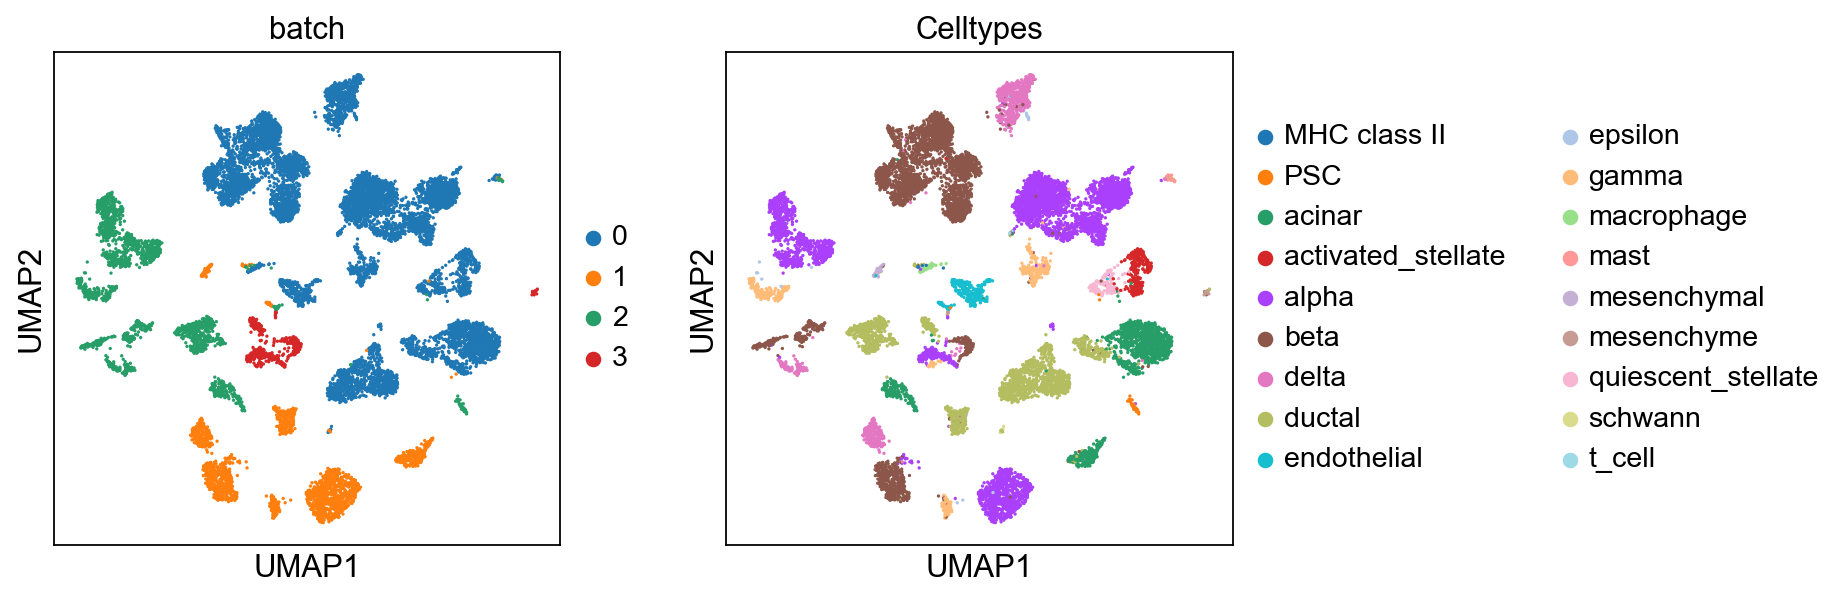

In [13]:
sc.pl.umap(adata, color = ["batch", "Celltypes"], save = "_pancreas_standard.pdf")

In [14]:
from bbtnn.tnn_v3 import *

In [15]:
%%time
model = TNN(k = 50, batch_size = 32, k_to_m_ratio = 1, n_epochs_without_progress = 5, verbose = 2)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
5594 cells defined as MNNs
Calculating KNNs
5594 cells defined as KNNs
Reorder
Training neural network
Epoch 1/1000
350/350 - 4s - loss: 0.8357
Epoch 2/1000
350/350 - 2s - loss: 0.4916
Epoch 3/1000
350/350 - 2s - loss: 0.4126
Epoch 4/1000
350/350 - 2s - loss: 0.3648
Epoch 5/1000
350/350 - 2s - loss: 0.3447
Epoch 6/1000
350/350 - 2s - loss: 0.3336
Epoch 7/1000
350/350 - 2s - loss: 0.3164
Epoch 8/1000
350/350 - 2s - loss: 0.2897
Epoch 9/1000
350/350 - 1s - loss: 0.2924
Epoch 10/1000
350/350 - 2s - loss: 0.2765
Epoch 11/1000
350/350 - 2s - loss: 0.2826
Epoch 12/1000
350/350 - 2s - loss: 0.2645
Epoch 13/1000
350/350 - 1s - loss: 0.2648
Epoch 14/1000
350/350 - 2s - loss: 0.2613
Epoch 15/1000
350/350 - 2s - loss: 0.2568
Epoch 16/1000
350/350 - 1s - loss: 0.2462
Epoch 17/1000
350/350 - 2s - loss: 0.2503
Epoch 18/1

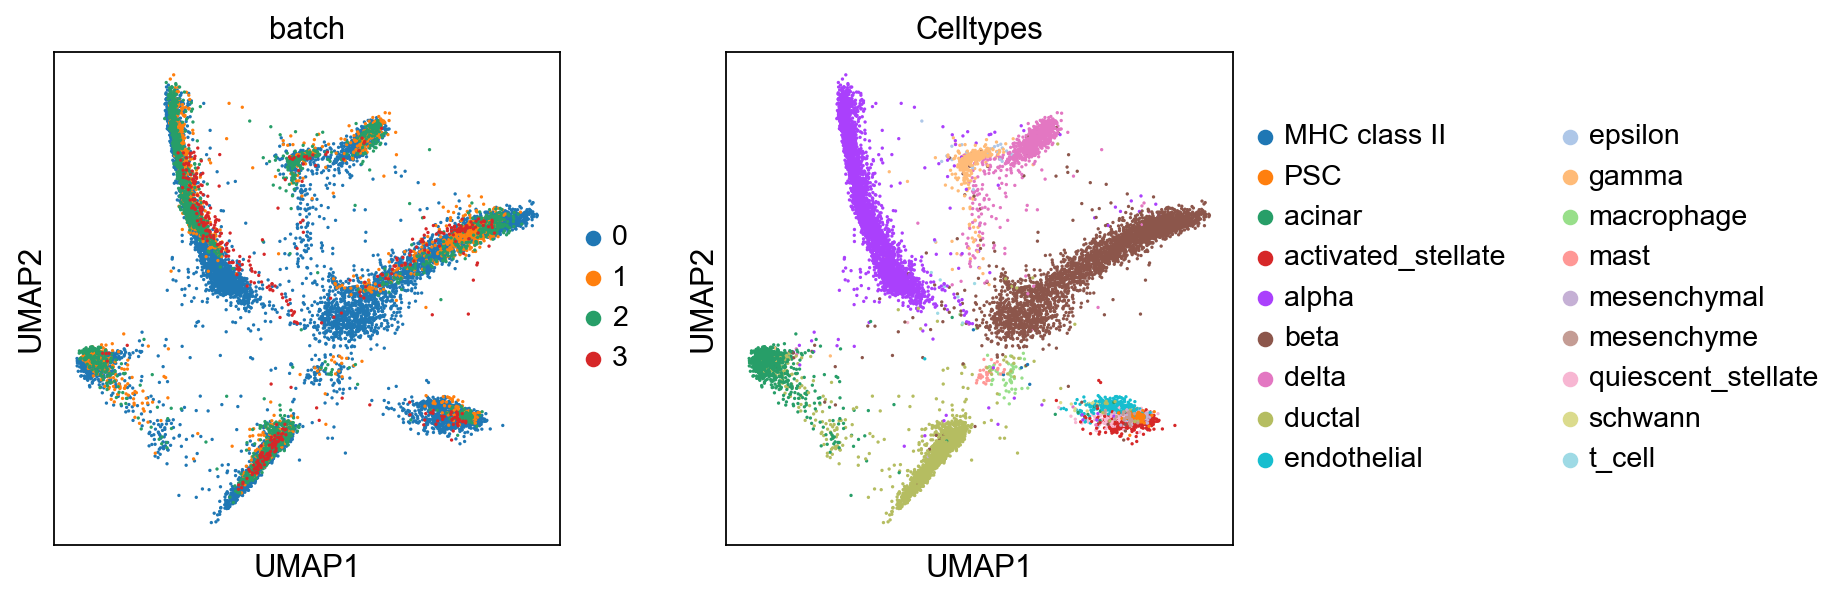

In [16]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "Celltypes"], save = "_pancreas_tnn.pdf")

### Add supervision to loss function

In [17]:
uniq = list(adata.obs["Celltypes"].unique())
y_labels = []
for i in adata.obs["Celltypes"]:
    y_labels.append(uniq.index(i))

In [20]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 5, verbose = 2, supervision_weight=1)
model.fit(X = adata, batch_name = "batch", Y = y_labels)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
5578 cells defined as MNNs
Calculating KNNs
4184 cells defined as KNNs
Reorder
Training neural network
Epoch 1/1000
306/306 - 5s - loss: 0.9432
Epoch 2/1000
306/306 - 2s - loss: 0.5410
Epoch 3/1000
306/306 - 2s - loss: 0.4493
Epoch 4/1000
306/306 - 2s - loss: 0.3975
Epoch 5/1000
306/306 - 2s - loss: 0.3786
Epoch 6/1000
306/306 - 2s - loss: 0.3438
Epoch 7/1000
306/306 - 2s - loss: 0.3352
Epoch 8/1000
306/306 - 2s - loss: 0.3202
Epoch 9/1000
306/306 - 2s - loss: 0.3216
Epoch 10/1000
306/306 - 2s - loss: 0.3003
Epoch 11/1000
306/306 - 2s - loss: 0.3012
Epoch 12/1000
306/306 - 2s - loss: 0.2833
Epoch 13/1000
306/306 - 2s - loss: 0.2844
Epoch 14/1000
306/306 - 2s - loss: 0.2759
Epoch 15/1000
306/306 - 1s - loss: 0.2735
Epoch 16/1000
306/306 - 2s - loss: 0.2701
Epoch 17/1000
306/306 - 1s - loss: 0.2670
Epoch 18/1

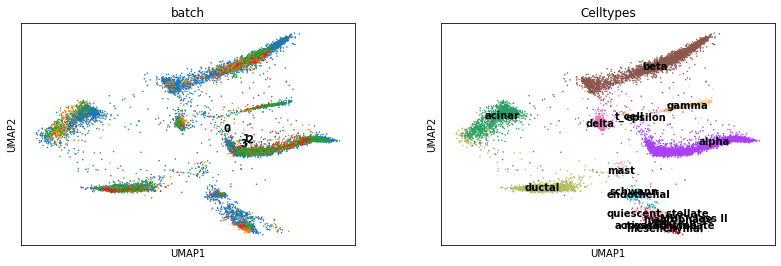

In [21]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "Celltypes"], legend_loc = "on data")

### Add semi-supervision to loss function

In [ ]:
mask = np.random.choice(range(len(Y_train)), size=len(Y_train) // 2, replace=False)
Y_train_masked = np.array(Y_train, dtype=np.int8) # Can't use uint to represent
Y_train_masked[mask] = -1